In [76]:
import geopandas as gpd
import itertools
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import shapely.geometry
from datetime import datetime
from itertools import combinations
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import warnings
import ptitprince as pt

warnings.filterwarnings("ignore")
from datetime import datetime

plt.rcParams.update(
    {
        "axes.titlesize": 24,  # Title font size
        "axes.labelpad": 10,  # Padding for the x and y labels
        "axes.labelcolor": "dimgray",
        "xtick.labelsize": 16,  # Font size for the x tick labels
        "ytick.labelsize": 16,  # Font size for the y tick labels
        "axes.labelsize": 20,  # Font size for the x and y axis labels
        "font.family": "Arial",  # Set the font family to Arial
        "grid.linestyle": "--",  # Set the style of the gridlines
        "grid.linewidth": 0.5,  # Set the width of the gridlines
        "grid.color": "gray",  # Set the color of the gridlines
        "axes.grid": True,  # Enable the grid
        "axes.grid.which": "both",  # Apply the grid to both major and minor ticks
        "xtick.direction": "in",  # Set the direction of the x tick marks
        "ytick.direction": "in",  # Set the direction of the y tick marks
        "xtick.major.size": 6,  # Set the length of the major x tick marks
        "xtick.major.width": 2,  # Set the width of the major x tick marks
        "ytick.major.size": 6,  # Set the length of the major y tick marks
        "ytick.major.width": 2,  # Set the width of the major y tick marks
        "xtick.color": "gray",  # Color of x tick labels and tick lines
        "ytick.color": "gray",  # Color of y tick labels and tick lines
    }
)




In [77]:
def clip_raster_to_aoi(filepath, bbox_geojson):
    bbox_geom = gpd.GeoDataFrame.from_features(
        [{"type": "Feature", "properties": {}, "geometry": bbox_geojson}],
        crs="EPSG:4326",
    )
    with rasterio.open(filepath) as src:
        src_crs = src.crs if src.crs else "EPSG:4326"
        bbox_geom = bbox_geom.to_crs(crs=src_crs)
        intersection = bbox_geom.unary_union.intersection(
            shapely.geometry.box(*src.bounds)
        )
        if not intersection.is_empty:
            out_image, out_transform = mask(src, shapes=[intersection], crop=True)
            out_meta = src.meta.copy()
            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "nodata": np.nan,
                }
            )
            return out_image.squeeze(), out_transform, out_meta


In [78]:
def align_raster(
    source_array,
    source_transform,
    source_meta,
    target_transform,
    target_crs,
    template_shape,
):
    aligned_array = np.empty(template_shape)
    reproject(
        source=source_array,
        destination=aligned_array,
        src_transform=source_transform,
        src_crs=source_meta["crs"],
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest,
    )
    return aligned_array


In [79]:
def preprocess_raster(array):
    array[(array < -10) | (array > 10)] = np.nan
    return array


In [80]:
def calculate_difference(array1, array2, date1, date2):
    valid_mask = np.isfinite(array1) & np.isfinite(array2)
    difference = array2 - array1
    difference[~valid_mask] = np.nan
    dt1 = datetime.strptime(date1, "%m/%d/%y")
    dt2 = datetime.strptime(date2, "%m/%d/%y")
    time_diff_years = (dt2 - dt1).days / 365.25
    print(f"Time difference: {np.round(time_diff_years, 1)} years")
    rate_of_change = difference / time_diff_years
    return rate_of_change


In [81]:
def create_raster_change_dataframe(z, dz):
    return pd.DataFrame({"Raster Values": z.flatten(), "dz/dt": dz.flatten()})


def plot_combined_accretion_erosion_density(dz, z, names):
    df = create_raster_change_dataframe(z, dz)
    accretion_df = df[df["dz/dt"] > 0]
    erosion_df = df[df["dz/dt"] < 0]

    plt.figure(figsize=(10, 8))

    sns.kdeplot(data=df, x="dz/dt", color="red", label="Total", linewidth=1.5)
    sns.kdeplot(data=accretion_df, x="dz/dt", color="green", label="Accretional", linewidth=1.5)
    sns.kdeplot(data=erosion_df, x="dz/dt", color="blue", label="Erosional", linewidth=1.5)

    plt.xlabel('dz/dt (m/yr)')
    plt.ylabel('Density')
    plt.title(f'{names[1]} - {names[0]}')
    plt.legend()
    plt.savefig(
        f"PDF Raster Differences ({names[0]} - {names[1]}).png",
        format="png",
        dpi=1200,
    )
    print(names)
    plt.show()



In [82]:
def load_and_preprocess_rasters(raster_pair, bbox_geojson):
    rasters = []
    names = []
    dates = []
    first_array_shape = None
    first_transform = None
    first_meta = None

    for path_info_tuple in raster_pair:
        path, (name, date) = path_info_tuple
        path = f"Data/{path}"
        if first_array_shape is None:
            array, transform, meta = clip_raster_to_aoi(path, bbox_geojson)
            first_array_shape = array.shape
            first_transform = transform
            first_meta = meta
        else:
            array, transform, meta = clip_raster_to_aoi(path, bbox_geojson)
            array = align_raster(
                array,
                transform,
                meta,
                first_transform,
                first_meta["crs"],
                first_array_shape,
            )
        array = preprocess_raster(array)
        rasters.append(array)
        names.append(name)
        dates.append(date)
    return rasters, names, dates


def calculate_differences_between_rasters(rasters, dates):
    difference = calculate_difference(rasters[0], rasters[1], dates[0], dates[1])
    return difference


def plot_results_and_generate_output(rasters, names, difference):
    plot_combined_accretion_erosion_density(difference, rasters[0], names)
    return None


def main(rasters_combination, bbox_geojson):
    for raster_pair in rasters_combination:
        rasters, names, dates = load_and_preprocess_rasters(raster_pair, bbox_geojson)
        difference = calculate_differences_between_rasters(rasters, dates)
        plot_results_and_generate_output(rasters, names, difference)


In [83]:
rasters_dict = {
    'Clipped(2001)_meter.tif': ('DEM 2001', '10/13/01'),
    "Clipped(2002)_meter.tif": ("DEM 2002", "9/18/02"),
    # "Clipped(2006)_meter.tif": ("DEM 2006", "4/26/06"),
    'Clipped(2009)_meter.tif': ('DEM 2009', '3/15/09'),
    # 'Clipped(2016)_meter.tif': ('DEM 2016', '8/31/16'),
    'Clipped(2018)_meter.tif': ('DEM 2018', '2/16/18'),
    '(Clipped)2018_19_post_harvey_meter.tif': ('DEM 2018_19_post_harvey', '2/9/19')
}


In [84]:
bbox_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [-95.514107383931105, 28.837294991608498],
            [-95.542191067157702, 28.82310160914],
            [-95.533023536824004, 28.807894014576299],
            [-95.5039012207138, 28.822751403692301],
            [-95.514107383931105, 28.837294991608498],
        ]
    ],
}


def replace_dem_with_month_year(rasters):
    updated_dict = {}
    for key, (_, date_str) in rasters.items():
        date_obj = datetime.strptime(date_str, "%m/%d/%y")
        month_year = date_obj.strftime("%b %Y")
        updated_dict[key] = (month_year, date_str)
    return updated_dict

rasters_dict = replace_dem_with_month_year(rasters_dict)


Time difference: 0.9 years
['Oct 2001', 'Sep 2002']


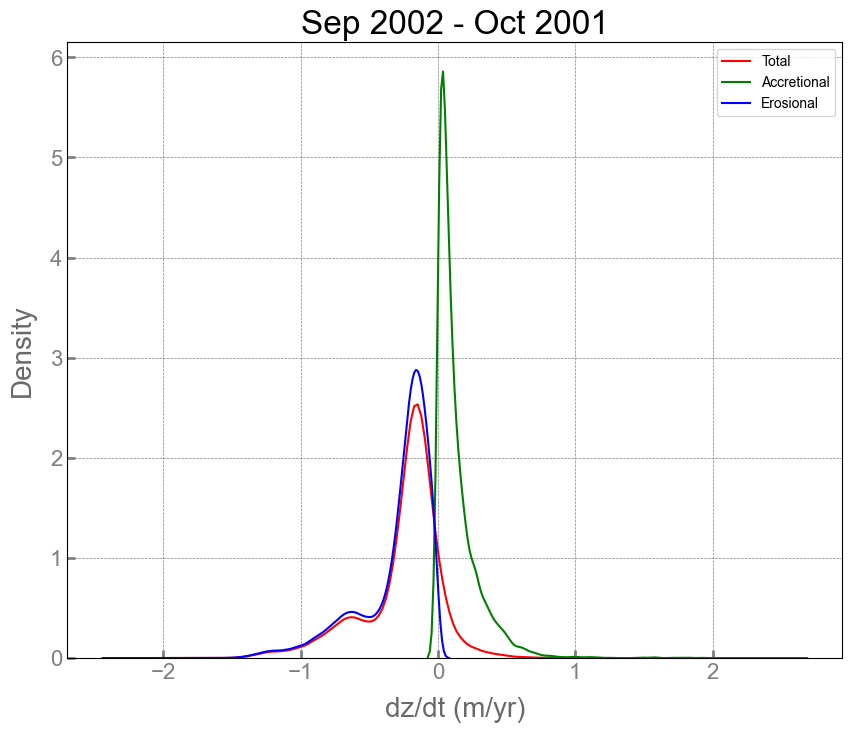

Time difference: 6.5 years
['Sep 2002', 'Mar 2009']


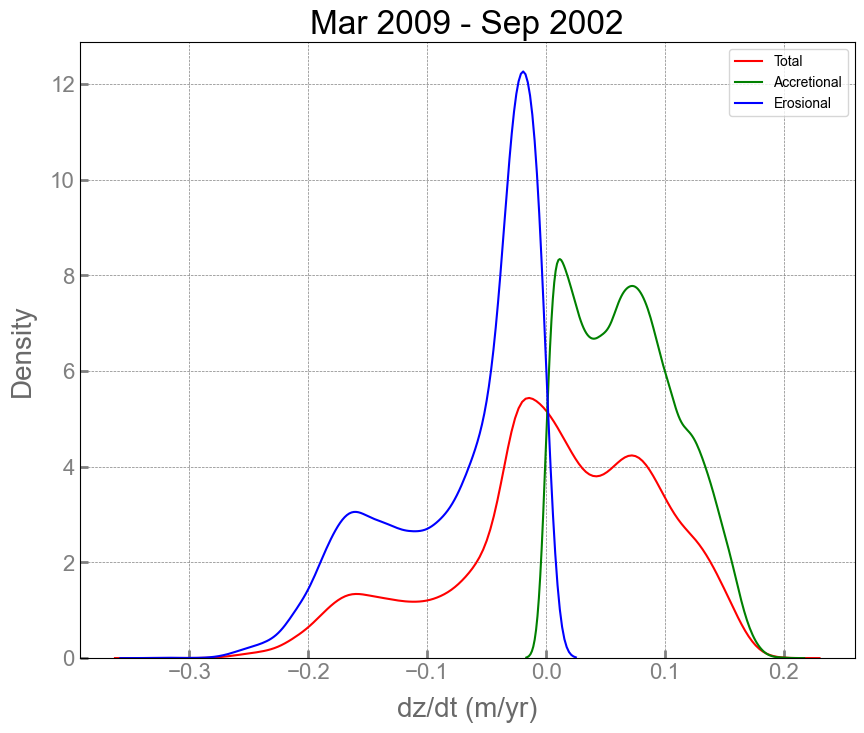

Time difference: 8.9 years
['Mar 2009', 'Feb 2018']


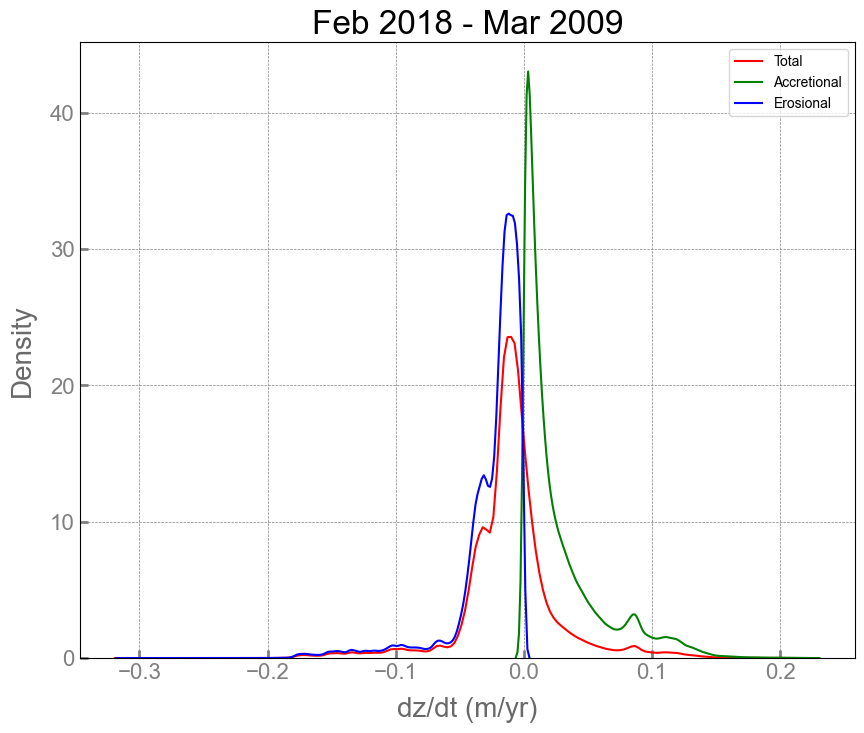

Time difference: 1.0 years
['Feb 2018', 'Feb 2019']


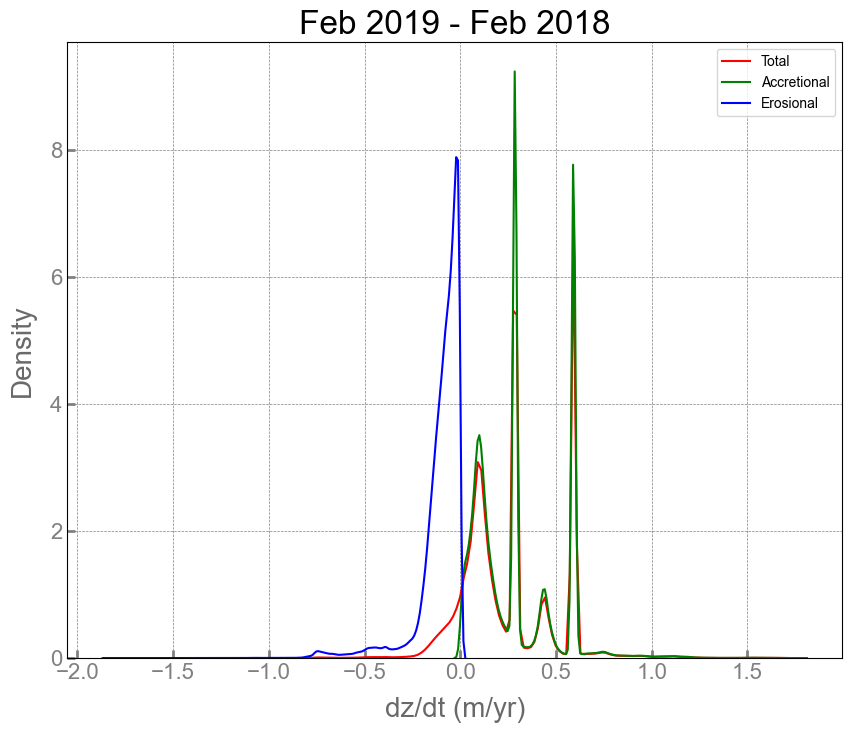

In [85]:
# rasters_combination = combinations(rasters_dict.items(), 2)
items = list(rasters_dict.items())
rasters_combination = []

for i in range(len(items) - 1):
    current_pair = [items[i], items[i + 1]]
    rasters_combination.append(current_pair)
results = main(rasters_combination, bbox_geojson)
